In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import shutil
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score

from tqdm import tqdm

from torchray.attribution.grad_cam import grad_cam as GradCAM
from captum.attr import LayerGradCam, visualization

In [ ]:
torch.manual_seed(1111)
np.random.seed(1111)

In [ ]:
images_path = '/content/drive/MyDrive/FinalProject/'

In [ ]:
paths = []
labels = []
data_sets = []

def get_paths_and_labels(folder):
    folder_path = os.path.join(images_path, folder)
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".png") or file.endswith(".jpg"):  # Ajusta la extensión según tus archivos
                file_path = os.path.join(root, file)
                paths.append(file_path)
                labels.append(os.path.basename(os.path.dirname(file_path)))
                data_sets.append(folder)

get_paths_and_labels('train')
get_paths_and_labels('valid')
get_paths_and_labels('test')

df = pd.DataFrame({'filepaths': paths, 'labels': labels, 'data set': data_sets})
df

,filepaths,labels,data set
0,/content/drive/MyDrive/FinalProject/train/Ukiy...,Ukiyo_e,train
1,/content/drive/MyDrive/FinalProject/train/Ukiy...,Ukiyo_e,train
2,/content/drive/MyDrive/FinalProject/train/Ukiy...,Ukiyo_e,train
3,/content/drive/MyDrive/FinalProject/train/Ukiy...,Ukiyo_e,train
4,/content/drive/MyDrive/FinalProject/train/Ukiy...,Ukiyo_e,train
...,...,...,...
15269,/content/drive/MyDrive/FinalProject/test/Abstr...,Abstract_Expressionism,test
15270,/content/drive/MyDrive/FinalProject/test/Abstr...,Abstract_Expressionism,test
15271,/content/drive/MyDrive/FinalProject/test/Abstr...,Abstract_Expressionism,test
15272,/content/drive/MyDrive/FinalProject/test/Analy...,Analytical_Cubism,test


In [ ]:
classes = df["labels"].unique()
num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

labels = classes.tolist()

numeric_values = list(range(len(labels)))

label_mapping = {}
for label, numeric_value in zip(labels, numeric_values):
    label_mapping[label] = numeric_value

df['labels'] = df['labels'].map(label_mapping)

df

Number of classes: 27
Classes: ['Ukiyo_e' 'Synthetic_Cubism' 'Symbolism' 'Rococo' 'Romanticism' 'Realism'
 'Pointillism' 'Pop_Art' 'Post_Impressionism' 'Northern_Renaissance'
 'Naive_Art_Primitivism' 'New_Realism' 'Minimalism'
 'Mannerism_Late_Renaissance' 'Impressionism' 'High_Renaissance'
 'Expressionism' 'Fauvism' 'Early_Renaissance' 'Contemporary_Realism'
 'Color_Field_Painting' 'Cubism' 'Baroque' 'Art_Nouveau_Modern'
 'Analytical_Cubism' 'Action_painting' 'Abstract_Expressionism']


,filepaths,labels,data set
0,/content/drive/MyDrive/FinalProject/train/Ukiy...,0,train
1,/content/drive/MyDrive/FinalProject/train/Ukiy...,0,train
2,/content/drive/MyDrive/FinalProject/train/Ukiy...,0,train
3,/content/drive/MyDrive/FinalProject/train/Ukiy...,0,train
4,/content/drive/MyDrive/FinalProject/train/Ukiy...,0,train
...,...,...,...
15269,/content/drive/MyDrive/FinalProject/test/Abstr...,26,test
15270,/content/drive/MyDrive/FinalProject/test/Abstr...,26,test
15271,/content/drive/MyDrive/FinalProject/test/Abstr...,26,test
15272,/content/drive/MyDrive/FinalProject/test/Analy...,24,test


In [ ]:
training_df = pd.DataFrame()
test_df = pd.DataFrame()
val_df = pd.DataFrame()

for label in df['data set'].unique():
    if label == 'train':
        training_df = df[df['data set'] == label]
    elif label == 'test':
        test_df = df[df['data set'] == label]
    elif label == 'valid':
        val_df = df[df['data set'] == label]

print(df.shape[0], ", ", training_df.shape[0] + test_df.shape[0] + val_df.shape[0])

training_df = training_df.drop('data set', axis=1)
test_df = test_df.drop('data set', axis=1)
val_df = val_df.drop('data set', axis=1)

training_df = training_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(training_df)
print(test_df)
print(val_df)

15274 ,  15274
                                               filepaths  labels
0      /content/drive/MyDrive/FinalProject/train/Ukiy...       0
1      /content/drive/MyDrive/FinalProject/train/Ukiy...       0
2      /content/drive/MyDrive/FinalProject/train/Ukiy...       0
3      /content/drive/MyDrive/FinalProject/train/Ukiy...       0
4      /content/drive/MyDrive/FinalProject/train/Ukiy...       0
...                                                  ...     ...
13345  /content/drive/MyDrive/FinalProject/train/Abst...      26
13346  /content/drive/MyDrive/FinalProject/train/Abst...      26
13347  /content/drive/MyDrive/FinalProject/train/Abst...      26
13348  /content/drive/MyDrive/FinalProject/train/Abst...      26
13349  /content/drive/MyDrive/FinalProject/train/Abst...      26

[13350 rows x 2 columns]
                                             filepaths  labels
0    /content/drive/MyDrive/FinalProject/test/Symbo...       2
1    /content/drive/MyDrive/FinalProject/test/Symbo..

In [ ]:
class MyTrainingDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data = df["filepaths"]  # Assuming your data are filepaths
        self.labels = df['labels']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data[index]
        img = Image.open(img_path)  # Load the image from the filepath

        # img = convert_grayscale_to_rgb(img)

        if self.transform:
            img = self.transform(img)  # Apply transformations if specified

        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.long)
        return img, label

In [ ]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

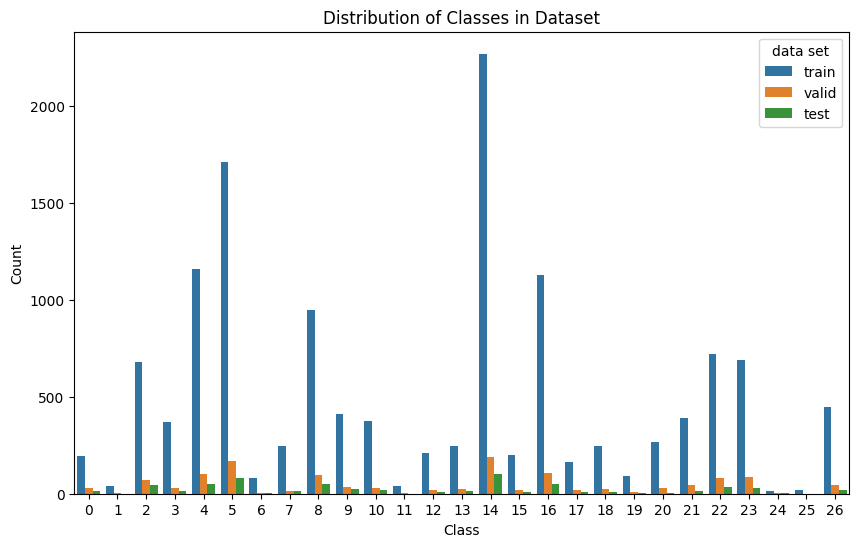

In [ ]:
# Distribución de Clases en el Conjunto de Datos
plt.figure(figsize=(10, 6))
sns.countplot(x='labels', hue='data set', data=df)
plt.title('Distribution of Classes in Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

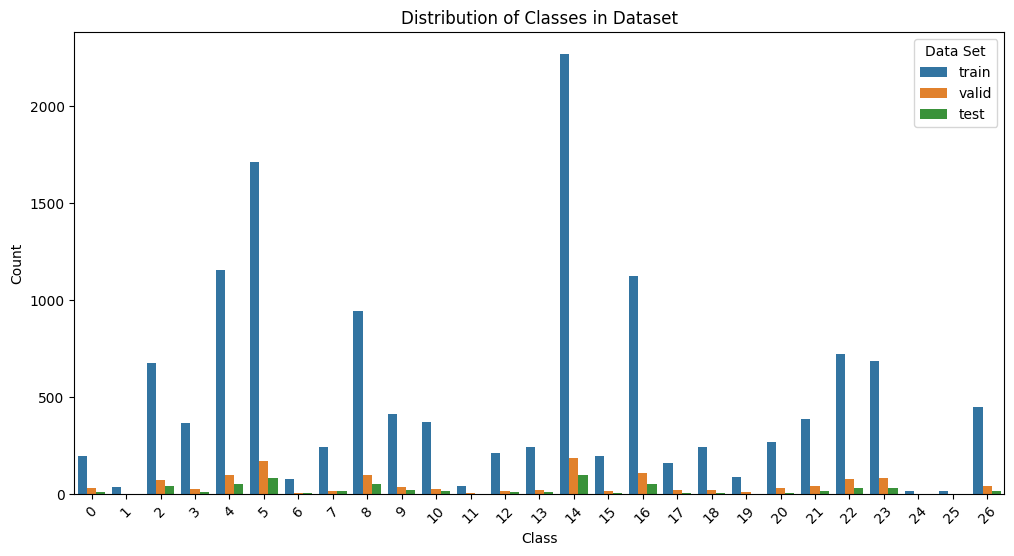

In [ ]:
# Distribución de Clases en el Conjunto de Datos (ampliado)
plt.figure(figsize=(12, 6))
sns.countplot(x='labels', hue='data set', data=df)
plt.title('Distribution of Classes in Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Data Set')
plt.show()


In [ ]:
# Frecuencia de Clases en el Conjunto de Datos (entrenamiento, validación, prueba)
train_freq = training_df['labels'].value_counts(normalize=True)
val_freq = val_df['labels'].value_counts(normalize=True)
test_freq = test_df['labels'].value_counts(normalize=True)

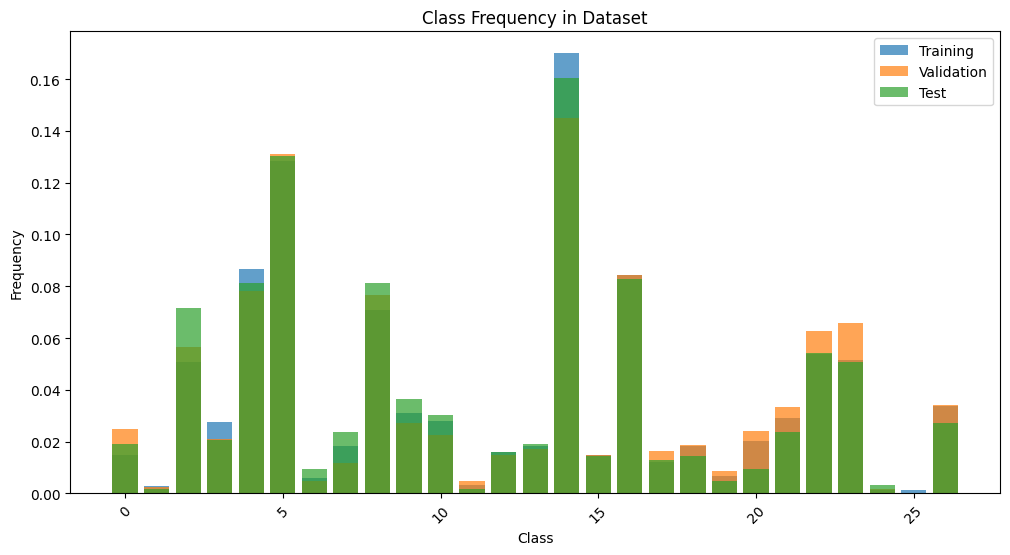

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(train_freq.index, train_freq.values, alpha=0.7, label='Training')
plt.bar(val_freq.index, val_freq.values, alpha=0.7, label='Validation')
plt.bar(test_freq.index, test_freq.values, alpha=0.7, label='Test')
plt.title('Class Frequency in Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

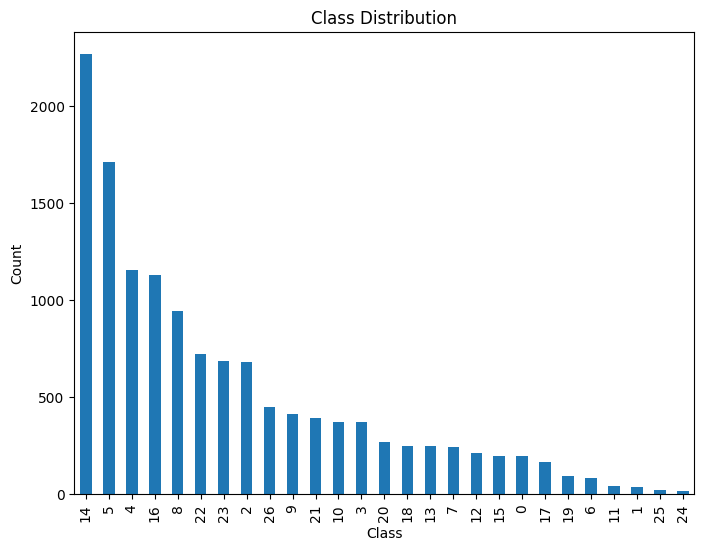

In [ ]:
def plot_class_distribution(dataset):
    plt.figure(figsize=(8, 6))
    dataset['labels'].value_counts().plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(training_df)

In [ ]:
def show_sample_images(dataset, num_images=5):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img, label = dataset[i]
        label_name = classes[label]  # Obtener el nombre de la categoría desde el diccionario de mapeo de etiquetas
        axs[i].imshow(img.permute(1, 2, 0))
        axs[i].set_title(f'Label: {label_name}')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

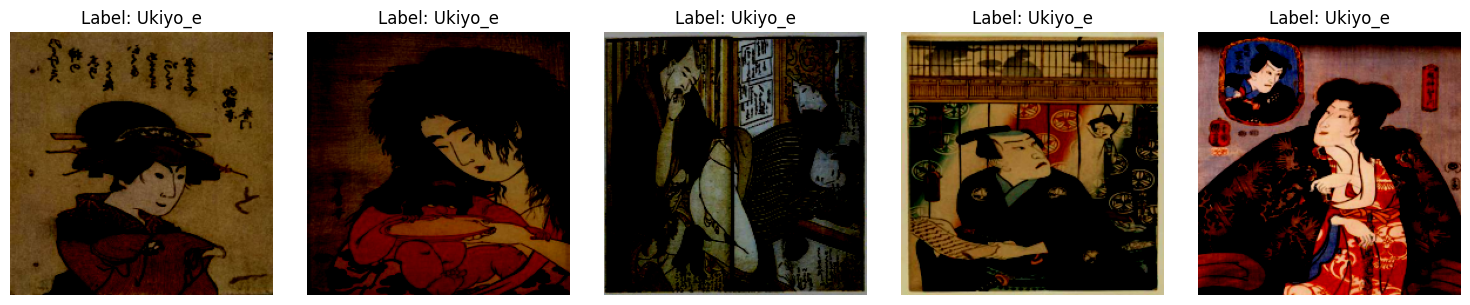

In [ ]:
# Mostrar algunas imágenes de ejemplo del conjunto de entrenamiento
show_sample_images(MyTrainingDataset(training_df, transform=transform))

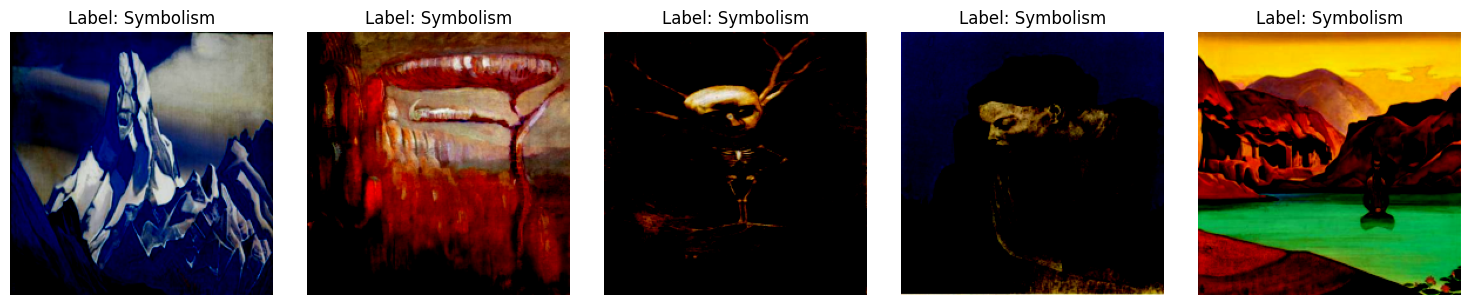

In [ ]:
# Muestra de Imágenes con Etiquetas (conjunto de prueba)
show_sample_images(MyTrainingDataset(test_df, transform=transform))

# RESNET18

In [ ]:
from torchvision.models import resnet18
import torchvision.models as models
import torch.optim as optim

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create an instance of the ResNet18 model
model = resnet18(pretrained=False, num_classes=num_classes)
model = model.to(device)

Using device: cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Define the transformations you want to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )  # Normalize the tensor
])

dataset = MyTrainingDataset(training_df, transform=transform)
training_data_loader = DataLoader(dataset, batch_size=36, num_workers=2, shuffle=True)

dataset = MyTrainingDataset(test_df, transform=transform)
test_data_loader = DataLoader(dataset, batch_size=36, num_workers=2, shuffle=True)

dataset = MyTrainingDataset(val_df, transform=transform)
val_data_loader = DataLoader(dataset, batch_size=36, num_workers=2, shuffle=True)

## Training RESNET18 with RGB

In [ ]:
if not os.path.exists('/content/drive/MyDrive/FinalProject/models/'):
    os.makedirs('/content/drive/MyDrive/FinalProject/models/')

num_epochs = 25

loss_history = []
precision_history = []

best_precision = 0.0  # Initialize the best precision
best_model_path = "/content/drive/MyDrive/FinalProject/models/best_model_resnet18.pth"  # Path to save the best model

In [ ]:
# Training loop
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for images, labels in training_data_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

        # Get predictions and true labels for precision calculation
        _, preds = torch.max(outputs, 1)  # Get predicted class indices
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Print the average loss for the current epoch
    epoch_loss = running_loss / len(training_data_loader)
    loss_history.append(epoch_loss)
    precision = precision_score(all_labels, all_preds, average="macro")
    precision_history.append(precision)
    print(f'Epoch [{epoch+1}/{num_epochs}], Precision: {precision:.4f}, loss: {epoch_loss:.4f}')

    # Check if the current precision is better than the previous best
    if precision > best_precision:
        best_precision = precision
        # Save the model
        torch.save(model.state_dict(), best_model_path)

print(f"Best precision achieved: {best_precision:.4f}. Model saved at {best_model_path}")

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/25], Precision: 0.0738, loss: 2.7279


  4%|▍         | 1/25 [28:16<11:18:35, 1696.49s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  8%|▊         | 2/25 [29:49<4:48:45, 753.29s/it]  

Epoch [2/25], Precision: 0.1053, loss: 2.5640


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 12%|█▏        | 3/25 [31:22<2:45:37, 451.69s/it]

Epoch [3/25], Precision: 0.1635, loss: 2.4400


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 16%|█▌        | 4/25 [32:54<1:48:25, 309.79s/it]

Epoch [4/25], Precision: 0.1890, loss: 2.3298


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|██        | 5/25 [34:25<1:16:53, 230.70s/it]

Epoch [5/25], Precision: 0.2212, loss: 2.2129


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 24%|██▍       | 6/25 [35:55<57:57, 183.00s/it]  

Epoch [6/25], Precision: 0.2838, loss: 2.1206


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 28%|██▊       | 7/25 [37:33<46:33, 155.21s/it]

Epoch [7/25], Precision: 0.2903, loss: 2.0164


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 32%|███▏      | 8/25 [39:08<38:34, 136.17s/it]

Epoch [8/25], Precision: 0.3812, loss: 1.8969


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 36%|███▌      | 9/25 [40:43<32:49, 123.11s/it]

Epoch [9/25], Precision: 0.3845, loss: 1.7511


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 40%|████      | 10/25 [42:19<28:43, 114.92s/it]

Epoch [10/25], Precision: 0.4859, loss: 1.5814


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 44%|████▍     | 11/25 [43:55<25:27, 109.12s/it]

Epoch [11/25], Precision: 0.5511, loss: 1.3425


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 48%|████▊     | 12/25 [45:30<22:39, 104.59s/it]

Epoch [12/25], Precision: 0.6140, loss: 1.1120


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 52%|█████▏    | 13/25 [47:04<20:18, 101.56s/it]

Epoch [13/25], Precision: 0.6678, loss: 0.8401


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 56%|█████▌    | 14/25 [48:38<18:10, 99.13s/it] 

Epoch [14/25], Precision: 0.7140, loss: 0.6460


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 60%|██████    | 15/25 [50:12<16:17, 97.77s/it]

Epoch [15/25], Precision: 0.7737, loss: 0.4577


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 64%|██████▍   | 16/25 [51:46<14:27, 96.43s/it]

Epoch [16/25], Precision: 0.8779, loss: 0.3317


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 68%|██████▊   | 17/25 [53:20<12:46, 95.87s/it]

Epoch [17/25], Precision: 0.9060, loss: 0.2202


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/25], Precision: 0.9225, loss: 0.1603


 72%|███████▏  | 18/25 [54:53<11:05, 95.08s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 76%|███████▌  | 19/25 [56:25<09:24, 94.00s/it]

Epoch [19/25], Precision: 0.9311, loss: 0.1202


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 80%|████████  | 20/25 [57:57<07:47, 93.55s/it]

Epoch [20/25], Precision: 0.9363, loss: 0.0934


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 84%|████████▍ | 21/25 [59:30<06:13, 93.31s/it]

Epoch [21/25], Precision: 0.9420, loss: 0.0687


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 88%|████████▊ | 22/25 [1:01:03<04:39, 93.16s/it]

Epoch [22/25], Precision: 0.9835, loss: 0.0576


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 23/25 [1:02:37<03:06, 93.47s/it]

Epoch [23/25], Precision: 0.9869, loss: 0.0500


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 96%|█████████▌| 24/25 [1:04:11<01:33, 93.54s/it]

Epoch [24/25], Precision: 0.9857, loss: 0.0438


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 25/25 [1:05:44<00:00, 157.77s/it]

Epoch [25/25], Precision: 0.9931, loss: 0.0342
Best precision achieved: 0.9931. Model saved at /content/drive/MyDrive/FinalProject/models/best_model_resnet18.pth


In [ ]:
best_model_resnet18 = models.resnet18(pretrained=False)

best_model_resnet18.fc = torch.nn.Linear(best_model_resnet18.fc.in_features, num_classes)

best_model_resnet18.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu'))) # en cpu usar , map_location=torch.device('cpu')

best_model_resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

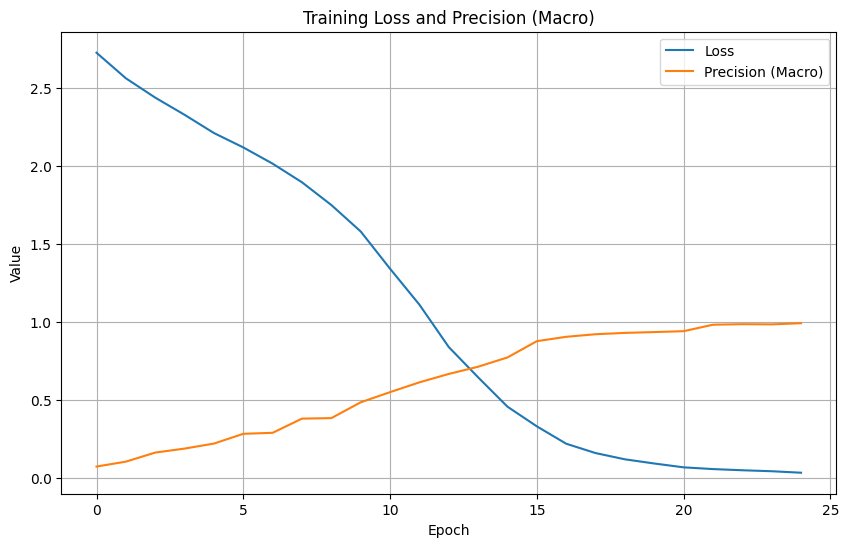

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(loss_history)), loss_history, label='Loss')
plt.plot(range(len(precision_history)), precision_history, label='Precision (Macro)')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Precision (Macro)')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/18 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 18/18 [01:25<00:00,  3.62s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 18/18 [01:26<00:00,  4.78s/it]


Accuracy: 0.2464
F1-score: 0.1644


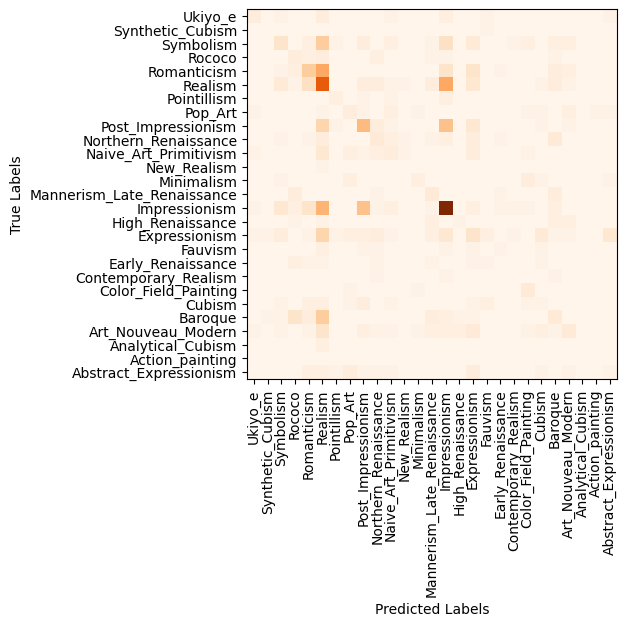

In [ ]:
import matplotlib.pyplot as plt

# Ensure that the device is set properly (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
best_model_resnet18.to(device)

# Initialize empty lists to store predictions and true labels
predictions = []
true_labels = []

# Disable gradient calculation and use torch.no_grad() to speed up computation
with torch.no_grad():
    # Iterate over the test data loader
    for images, labels in tqdm(test_data_loader, total=len(test_data_loader)):
        # Move images and labels to the device (GPU if available)
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        outputs = best_model_resnet18(images)

        # Compute predictions by taking the argmax of the output scores
        _, preds = torch.max(outputs, 1)

        # Convert predictions and labels to numpy arrays and store them
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy and F1-score
test_accuracy = accuracy_score(true_labels, predictions)
test_f1 = f1_score(true_labels, predictions, average='macro')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Print accuracy and F1-score
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-score: {test_f1:.4f}")

# Visualize confusion matrix
plt.imshow(conf_matrix, cmap="Oranges")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(np.arange(num_classes), classes, rotation=90)
plt.yticks(np.arange(num_classes), classes)
plt.show()

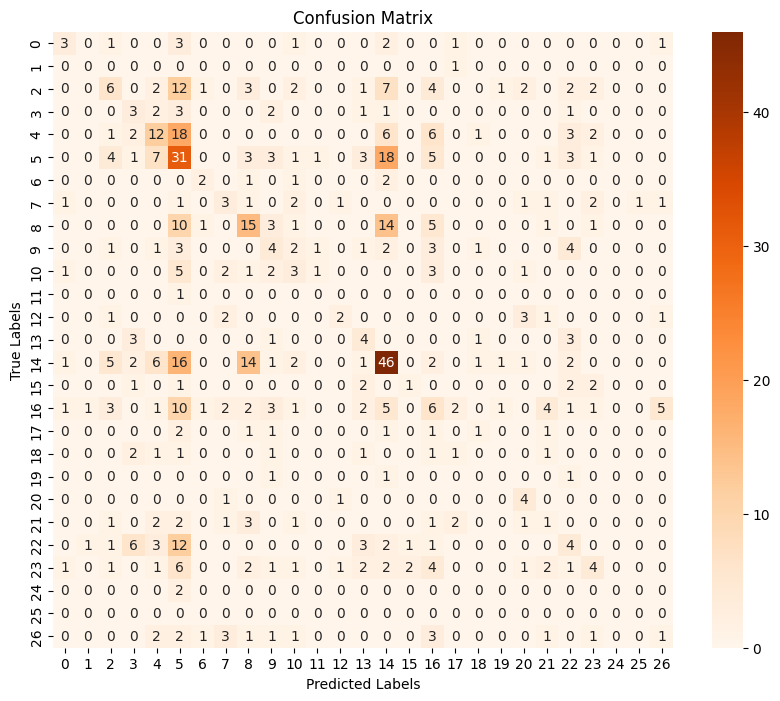

In [ ]:
# Matriz de Confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

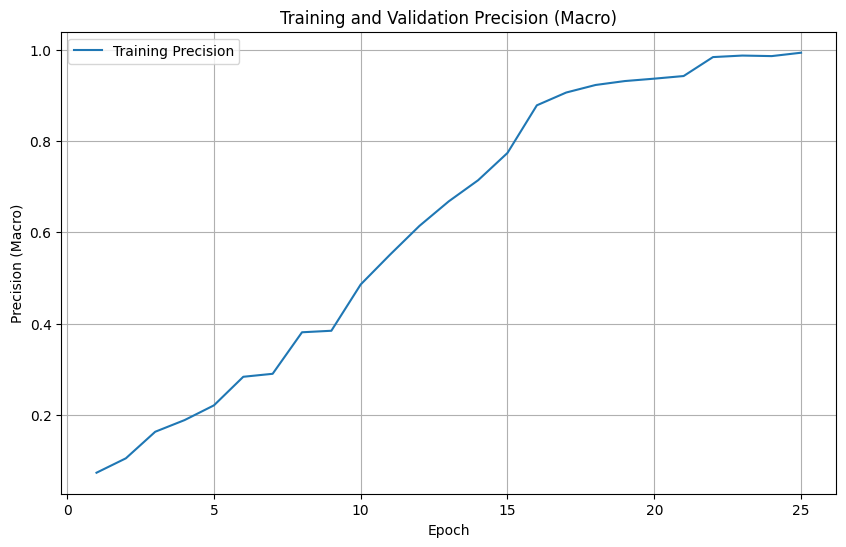

In [ ]:
# Comparación de Precisiones en Entrenamiento y Validación
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), precision_history, label='Training Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision (Macro)')
plt.title('Training and Validation Precision (Macro)')
plt.legend()
plt.grid(True)
plt.show()

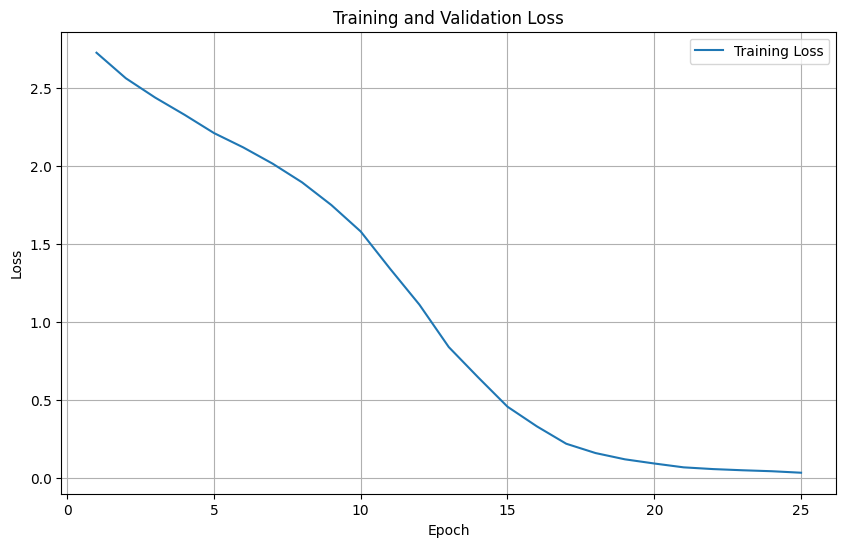

In [ ]:
# Comparación de Pérdidas en Entrenamiento y Validación
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

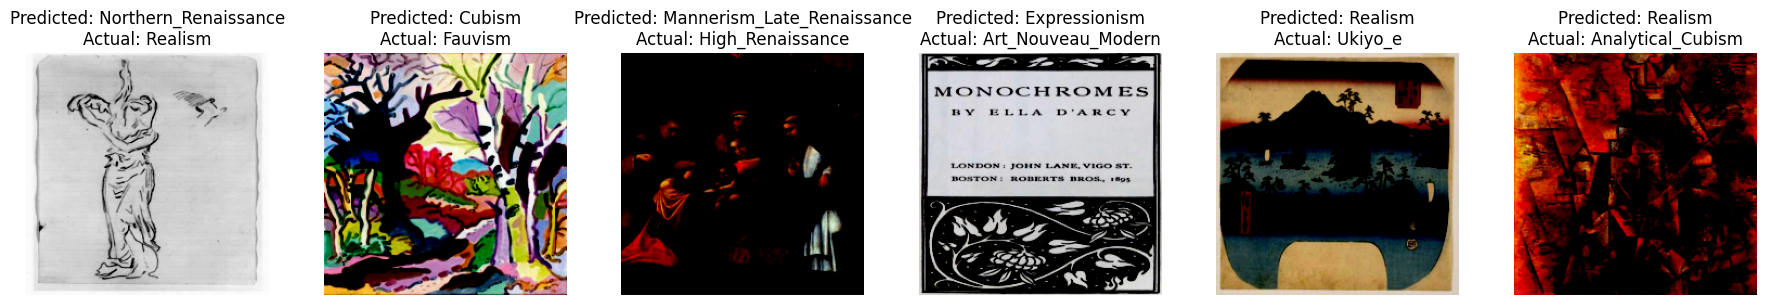

In [ ]:
# Visualización de Predicciones Incorrectas
def visualize_incorrect_predictions(model, data_loader):
    model.eval()
    incorrect_samples = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    incorrect_samples.append((images[i].cpu(), predicted[i].cpu().item(), labels[i].cpu().item()))
                    if len(incorrect_samples) >= 6:
                        break
                if len(incorrect_samples) >= 6:
                    break
    plt.figure(figsize=(18, 3))
    for i, (image, predicted, label) in enumerate(incorrect_samples):
        if i >= 6:  # Salir después de procesar 5 imágenes incorrectas
          break
        plt.subplot(1, 6, i+1)
        plt.imshow(image.permute(1, 2, 0).numpy())
        predicted_name = classes[predicted]
        actual_name = classes[label]
        plt.title(f'Predicted: {predicted_name}\nActual: {actual_name}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_incorrect_predictions(model, test_data_loader)

In [ ]:
# def visualize_grad_cam(model, image_tensor, target_class, original_image):
#     model.eval()
#     image_tensor = image_tensor.to(device)
#     layer_gc = LayerGradCam(model, model.layer4)  # Assuming 'layer4' is the last convolutional layer
#     attr = layer_gc.attribute(image_tensor, target=target_class)

#     if isinstance(attr, tuple):  # Verificar si attr es una tupla
#         attr = attr[0]  # Si es una tupla, obtener el primer elemento (debería ser el tensor)

#     print("Shape of attr before visualization:", attr.shape)  # Verificar la forma de attr

#     attr = visualization.visualize_image_attr(attr.detach().cpu().numpy(), original_image, method="blended_heat_map")  # Se proporciona la imagen original aquí
#     plt.imshow(attr.transpose(1, 2, 0))
#     plt.axis('off')
#     plt.show()

# # Cargar una imagen de ejemplo
# example_image_path = '/content/drive/MyDrive/FinalProject/train/Synthetic_Cubism/pablo-picasso_guitar-glass-and-bottle-of-vieux-marc-1912_jpg.rf.a8fd27ce163bb09094ce15a84d5eb0d6.jpg'
# example_image = Image.open(example_image_path)

# # Transformar la imagen para que coincida con las transformaciones que se aplican en el DataLoader
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # Aplicar las transformaciones a la imagen de ejemplo
# image_tensor = transform(example_image).unsqueeze(0)

# # Definir la clase objetivo (target_class) para la que se visualizará Grad-CAM
# target_class = 21  # Reemplaza 0 con la clase objetivo adecuada

# # Llamar a visualize_grad_cam con la imagen de ejemplo y la clase objetivo
# visualize_grad_cam(model, image_tensor, target_class, example_image)

NameError: name 'Image' is not defined

In [ ]:
# all_preds = []
# all_labels = []
# predictions = []
# true_labels = []

# with torch.no_grad():
#     for images, labels in tqdm(test_data_loader, total=len(test_data_loader)):
#         images, labels = images.to(device), labels.to(device)
#         outputs = best_model_resnet18(images)
#         _, preds = torch.max(outputs, 1)

#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

#         # Almacenar predicciones y etiquetas
#         predictions.extend(preds.cpu().numpy())
#         true_labels.extend(labels.cpu().numpy())

# test_accuracy = accuracy_score(all_labels, all_preds)
# test_f1 = f1_score(all_labels, all_preds, average='macro')

# # Calcular y visualizar la matriz de confusión
# confusion_matrix = confusion_matrix(true_labels, predictions)
# print(f"Accuracy: {test_accuracy:.4f}")
# print(f"F1-score: {test_f1:.4f}")

# plt.imshow(confusion_matrix, cmap="Oranges")
# plt.xlabel("Etiquetas Predichas")
# plt.ylabel("Etiquetas Reales")
# plt.xticks(np.arange(num_classes), classes, rotation=45)
# plt.yticks(np.arange(num_classes), classes)
# plt.show()

 22%|██▏       | 4/18 [00:01<00:04,  3.20it/s]


KeyboardInterrupt: 